In [10]:
import numpy as np
import os
import cv2
def noisy(noise_typ,image):
   if noise_typ == "gauss":
      row,col,ch= image.shape
      mean = 0
      var = 0.1
      sigma = var**0.5
      gauss = np.random.normal(mean,sigma,(row,col,ch))
      gauss = gauss.reshape(row,col,ch)
      noisy = image + gauss
      return noisy
   elif noise_typ == "s&p":
      row,col,ch = image.shape
      s_vs_p = 0.5
      amount = 0.004
      out = np.copy(image)
      # Salt mode
      num_salt = np.ceil(amount * image.size * s_vs_p)
      coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
      out[coords] = 1

      # Pepper mode
      num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
      coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
      out[coords] = 0
      return out
   elif noise_typ == "poisson":
      vals = len(np.unique(image))
      vals = 2 ** np.ceil(np.log2(vals))
      noisy = np.random.poisson(image * vals) / float(vals)
      return noisy
   elif noise_typ =="speckle":
      row,col,ch = image.shape
      gauss = np.random.randn(row,col,ch)
      gauss = gauss.reshape(row,col,ch)        
      noisy = image + image * gauss
      return noisy

In [11]:
import matplotlib.pyplot as plt


my_img = cv2.imread('MRI_of_Human_Brain.jpg')
cv2.imwrite('MRI_of_Human_Brain_Bruit_Gauss.jpg',
            noisy("gauss",my_img))

True

In [12]:
import random
import cv2
import numpy as np
import cv2
from matplotlib import pyplot as plt
from PIL import Image, ImageFilter
from skimage.metrics import peak_signal_noise_ratio as PSNR
 
def add_noise(img):
 
    # Getting the dimensions of the image
    row , col = img.shape
     
    # Randomly pick some pixels in the
    # image for coloring them white
    # Pick a random number between 300 and 10000
    number_of_pixels = random.randint(300, 10000)
    for i in range(number_of_pixels):
       
        # Pick a random y coordinate
        y_coord=random.randint(0, row - 1)
         
        # Pick a random x coordinate
        x_coord=random.randint(0, col - 1)
         
        # Color that pixel to white
        img[y_coord][x_coord] = 255
         
    # Randomly pick some pixels in
    # the image for coloring them black
    # Pick a random number between 300 and 10000
    number_of_pixels = random.randint(300 , 10000)
    for i in range(number_of_pixels):
       
        # Pick a random y coordinate
        y_coord=random.randint(0, row - 1)
         
        # Pick a random x coordinate
        x_coord=random.randint(0, col - 1)
         
        # Color that pixel to black
        img[y_coord][x_coord] = 0
         
    return img
 


In [13]:
# salt-and-pepper noise can
# be applied only to grayscale images
# Reading the color image in grayscale image
img = cv2.imread('MRI_of_Human_Brain.jpg',
                 cv2.IMREAD_GRAYSCALE)
 
#Storing the image
cv2.imwrite('MRI_of_Human_Brain_bruit_S&P.jpg',
            add_noise(img))

True

In [14]:
from skimage import io, img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from scipy.signal import convolve2d
import math
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as PSNR
from skimage.restoration import denoise_wavelet, denoise_nl_means, estimate_sigma
import cv2

def RMSE(imageA, imageB):
    diffrence = np.subtract(imageA, imageB)
    sqre_err = np.square(diffrence)
    rslt_meansqre_err = sqre_err.mean()
    root_meansqre_err = math.sqrt(rslt_meansqre_err)
    return root_meansqre_err

img1 = cv2.imread("MRI_of_Human_Brain_bruit_S&P.jpg", 0)
img1 = img1.astype(float)
img2 = cv2.imread("MRI_of_Human_Brain_bruit_Gauss.jpg", 0)
img2 = img2.astype(float)
original=cv2.imread("MRI_of_Human_Brain.jpg", 0)
noise1 = estimate_sigma(img1)
noise2 = estimate_sigma(img2)

#
uniform_filtered_img1 = ndimage.uniform_filter(img1, size=3)
uniform_filtered_img2 = ndimage.uniform_filter(img2, size=3)

#
blurred_img1 = ndimage.gaussian_filter(img1, sigma=3)  
blurred_img2 = ndimage.gaussian_filter(img2, sigma=0.1)

# Remplace l'entrée par la valeur médiane de ces voisins (window : généralement 3)
median_img1 = ndimage.median_filter(img1, 3)
median_img2 = ndimage.median_filter(img2, 3)

# Prend le moyenne de l'ensemnle des patchs de l'image, puis les pondère en fonction de la ressemblance avec le pixel cible
dst1 = denoise_nl_means(img1, patch_size=7)
dst2 = denoise_nl_means(img2, patch_size=7)

RMSE_gauss1=RMSE(original, blurred_img1)
RMSE_gauss2=RMSE(original, blurred_img2)

RMSE_med1=RMSE(original, median_img1)
RMSE_med2=RMSE(original, median_img2)

RMSE_uni1=RMSE(original, uniform_filtered_img1)
RMSE_uni2=RMSE(original, uniform_filtered_img2)

RMSE_dst1=RMSE(original, dst1)
RMSE_dst2=RMSE(original, dst2)

ssim_gauss1=ssim(original,blurred_img1)
ssim_gauss2=ssim(original,blurred_img2)

ssim_med1=ssim(original,median_img1)
ssim_med2=ssim(original,median_img2)

ssim_uni1=ssim(original,uniform_filtered_img1)
ssim_uni2=ssim(original,uniform_filtered_img2)

ssim_dst1=ssim(original,dst1)
ssim_dst2=ssim(original,dst2)

# set up side-by-side image display
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(25)

fig.add_subplot(2,5,1)
plt.imshow(img1, cmap='gray')
plt.title('Original s&p noise')

fig.add_subplot(2,5,2)
plt.imshow(blurred_img1, cmap='gray')
plt.title("Gauss\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_gauss1,PSNR(original,blurred_img1),ssim_gauss1))

fig.add_subplot(2,5,3)
plt.imshow(median_img1, cmap='gray')
plt.title("Median\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_med1,PSNR(original,median_img1),ssim_med1))

fig.add_subplot(2,5,4)
plt.imshow(uniform_filtered_img1, cmap='gray')
plt.title("Uniform\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_uni1,PSNR(original,uniform_filtered_img1),ssim_uni1))

fig.add_subplot(2,5,5)
plt.imshow(dst1, cmap='gray')
plt.title("NLfastMean\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_dst1,PSNR(original,dst1),ssim_dst1))

fig.add_subplot(2,5,6)
plt.imshow(img2, cmap='gray')
plt.title('Original gauss noise')

fig.add_subplot(2,5,7)
plt.imshow(blurred_img2, cmap='gray')
plt.title("Gauss\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_gauss2,PSNR(original,blurred_img2),ssim_gauss2))

fig.add_subplot(2,5,8)
plt.imshow(median_img2, cmap='gray')
plt.title("Median\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_med2,PSNR(original,median_img2),ssim_med2))

fig.add_subplot(2,5,9)
plt.imshow(uniform_filtered_img2, cmap='gray')
plt.title("Uniform\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_uni2,PSNR(original,uniform_filtered_img2),ssim_uni2))

fig.add_subplot(2,5,10)
plt.imshow(dst2, cmap='gray')
plt.title("NLfastMean\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_dst2,PSNR(original,dst2),ssim_dst2))

C:\Users\junda\AppData\Local\Temp/ipykernel_17784/168700711.py:55: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ssim_gauss1=ssim(original,blurred_img1)
C:\Users\junda\AppData\Local\Temp/ipykernel_17784/168700711.py:56: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ssim_gauss2=ssim(original,blurred_img2)
C:\Users\junda\AppData\Local\Temp/ipykernel_17784/168700711.py:58: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ssim_med1=ssim(original,median_img1)
C:\Users\junda\AppData\Local\Temp/ipykernel_17784/168700711.py:59: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ssim_med2=ssim(original,median_img2)
C:\Users\junda\AppData\Local\Temp/ipykernel_17784/168700711.py:61: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ssim_uni1=ssim(original,uniform_filtered_img1)
C:\Users\junda\AppData\Local\Temp/ipyke

Text(0.5, 1.0, 'NLfastMean\n RMSE : 0.611207849449288\n PSNR : 52.4070251478951\n SSIM : 0.9992392097115576')

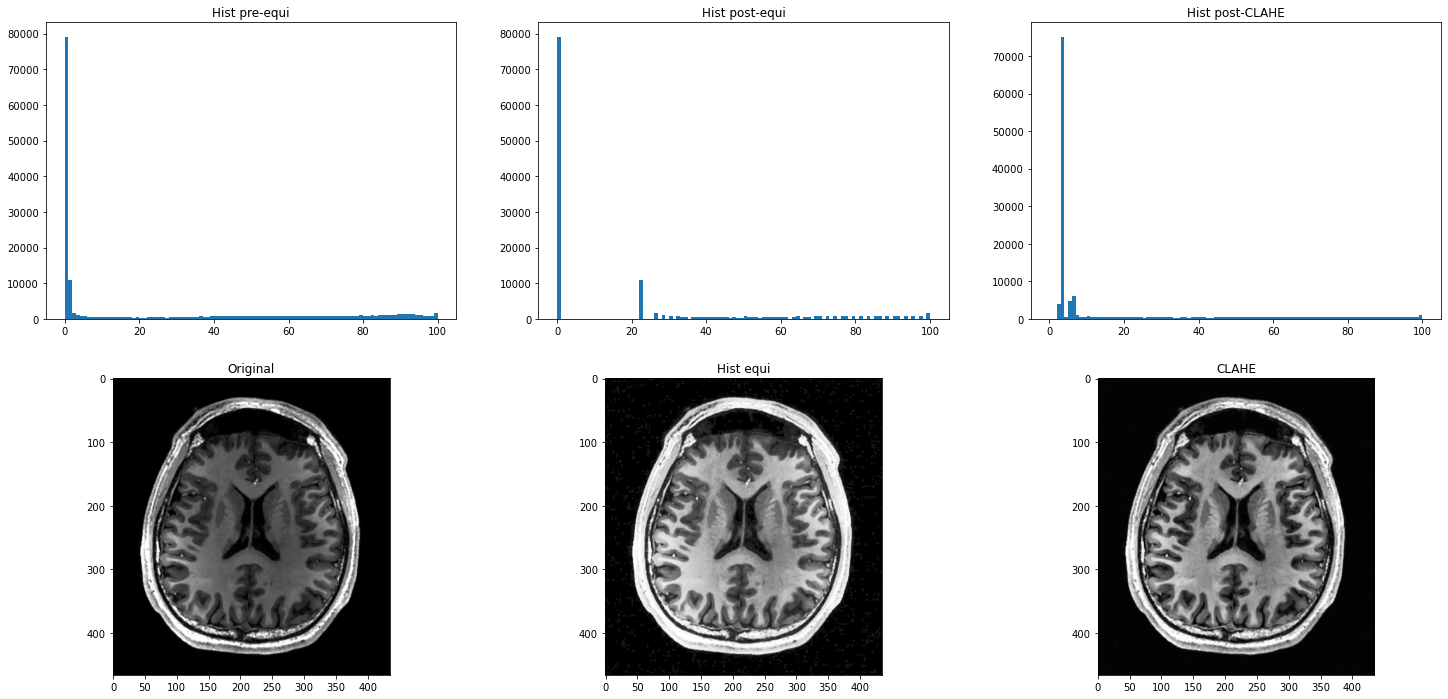

In [16]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

cv2.imwrite('MRI_filter_result.jpg',median_img1)
img = cv2.imread('MRI_filter_result.jpg',0)

equ = cv2.equalizeHist(img)

#Together the algorithm is called: Contrast Limited Adaptive Histogram Equalization (CLAHE)

# Start by creating a CLAHE object (Arguments are optional).
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))  #Define tile size and clip limit. 
cl1 = clahe.apply(img)

fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(25)

fig.add_subplot(2,3,1)
plt.hist(img.flat, bins=100, range=(0,100))
plt.title('Hist pre-equi')

fig.add_subplot(2,3,2)
plt.hist(equ.flat, bins=100, range=(0,100))
plt.title('Hist post-equi')

fig.add_subplot(2,3,3)
plt.hist(cl1.flat, bins=100, range=(0,100))
plt.title('Hist post-CLAHE')

fig.add_subplot(2,3,4)
plt.imshow(img, cmap='gray')
plt.title('Original')

fig.add_subplot(2,3,5)
plt.imshow(equ, cmap='gray')
plt.title('Hist equi')

fig.add_subplot(2,3,6)
plt.imshow(cl1, cmap='gray')
plt.title('CLAHE')

plt.show()

In [ ]:
from skimage.filters import try_all_threshold, threshold_otsu
result = try_all_threshold(median_img1)

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen
